# Importe as bibliotecas necessárias (instalações comentadas)

In [ ]:
# Instalar o TensorFlow se necessário
#!pip install tensorflow
#!pip install kagglehub
#!pip install keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from kagglehub import KaggleDatasetAdapter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

# Pré-processamento de dados (ETL)

Carregando o dataset House Prices diretamente do Kaggle

In [3]:
file_path = "train.csv"

df = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    "lespin/house-prices-dataset",
    file_path,
)

C:\Users\Welton Dionisio\AppData\Local\Temp\ipykernel_21208\2325293316.py:3: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


Conferindo a estrutura dos dados carregados

In [4]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


Tratamento de dados ausentes, codificação de dados categóricos em variáveis dummies e segregação de variáveis preditoras e alvo

In [6]:
# Remover colunas com muitos nulos e preencher outras
df.fillna(df.median(numeric_only=True), inplace=True)
df.fillna("None", inplace=True)

# Codificação das variáveis categóricas
cat_cols = df.select_dtypes(include=["object"]).columns
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

# Separar variáveis preditoras e alvo
X = df.drop(columns=["SalePrice", "Id"])
y = df["SalePrice"]

# Treinamento e Arquitetura do Modelo de Rede Neural

Padronização dos dados (melhorar a escala) e separação de dados de treino e teste

In [7]:
# Escalar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Separar treino/teste novamente com os dados escalados
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Treinamento do modelo (rede neural com 64 neurônios na camada de entrada, 32 na camada oculta e 1 neurônio de saída)

In [8]:
# Criar o modelo
model_nn = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')  # saída com ativação linear para regressão
])

# Compilar o modelo
model_nn.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])

# Treinar o modelo
history = model_nn.fit(X_train, y_train, epochs=100, batch_size=32,
                       validation_split=0.2, verbose=0)

C:\Users\Welton Dionisio\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Validação do modelo

In [11]:
# Avaliação no conjunto de teste
loss, mae = model_nn.evaluate(X_test, y_test, verbose=0)
y_pred_nn = model_nn.predict(X_test).flatten()

# Métricas adicionais
mse = mean_squared_error(y_test, y_pred_nn)
r2 = r2_score(y_test, y_pred_nn)

print(f"MAE (NN): {mae:.4f}")
print(f"MSE (NN): {mse:.4f}")
print(f"R² (NN): {r2:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
MAE (NN): 23781.7422
MSE (NN): 1245562209.4948
R² (NN): 0.8376


# Visualização de desempenho da previsão e do treinamento

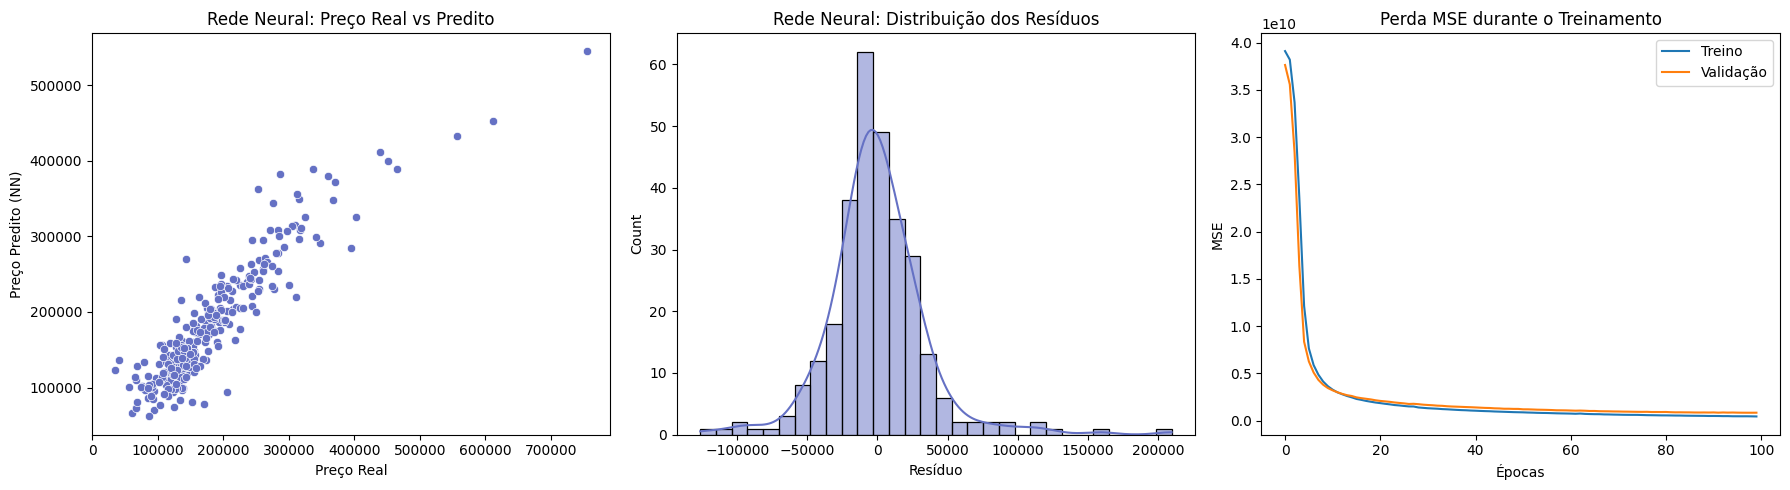

In [12]:
# Comparação entre valores reais de preço dos imóveis e preço previsto
plt.figure(figsize=(18, 5))

# Gráfico de dispersão
plt.subplot(1, 3, 1)
sns.scatterplot(x=y_test, y=y_pred_nn, color='#6571c4')
plt.xlabel("Preço Real")
plt.ylabel("Preço Predito (NN)")
plt.title("Rede Neural: Preço Real vs Predito")

# Resíduos
plt.subplot(1, 3, 2)
residuals_nn = y_test - y_pred_nn
sns.histplot(residuals_nn, bins=30, color='#6571c4', kde=True)
plt.title("Rede Neural: Distribuição dos Resíduos")
plt.xlabel("Resíduo")

# Curva de perda
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda MSE durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

# Otimização e Regularização da Rede Neural

- Dropout: reduz o overfitting zerando aleatoriamente alguns neurônios durante o treinamento.

- EarlyStopping: para o treinamento automaticamente se a validação não estiver melhorando.

- Ajuste básico de hiperparâmetros: camadas, taxa de aprendizado, epochs.

In [16]:
# Criar o modelo com Dropout
model_nn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(192, activation='relu'),
    Dropout(0.4),
    Dense(50, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='relu')  # saída linear para regressão
])

# Compilar o modelo
model_nn.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


C:\Users\Welton Dionisio\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Treinamento e validação do novo modelo

In [17]:
# Treinar o modelo
history = model_nn.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=0
)

# Avaliação no conjunto de teste
loss, mae = model_nn.evaluate(X_test, y_test, verbose=0)
y_pred_nn = model_nn.predict(X_test).flatten()

# Métricas
mse = mean_squared_error(y_test, y_pred_nn)
r2 = r2_score(y_test, y_pred_nn)

print(f"MAE (NN + melhorias): {mae:.2f}")
print(f"MSE (NN + melhorias): {mse:.2f}")
print(f"R² (NN + melhorias): {r2:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
MAE (NN + melhorias): 22089.43
MSE (NN + melhorias): 1108645416.23
R² (NN + melhorias): 0.8555


Uma melhoria de cerca de 2% em relação ao modelo anterior.

# Visualização de desempenho do novo modelo

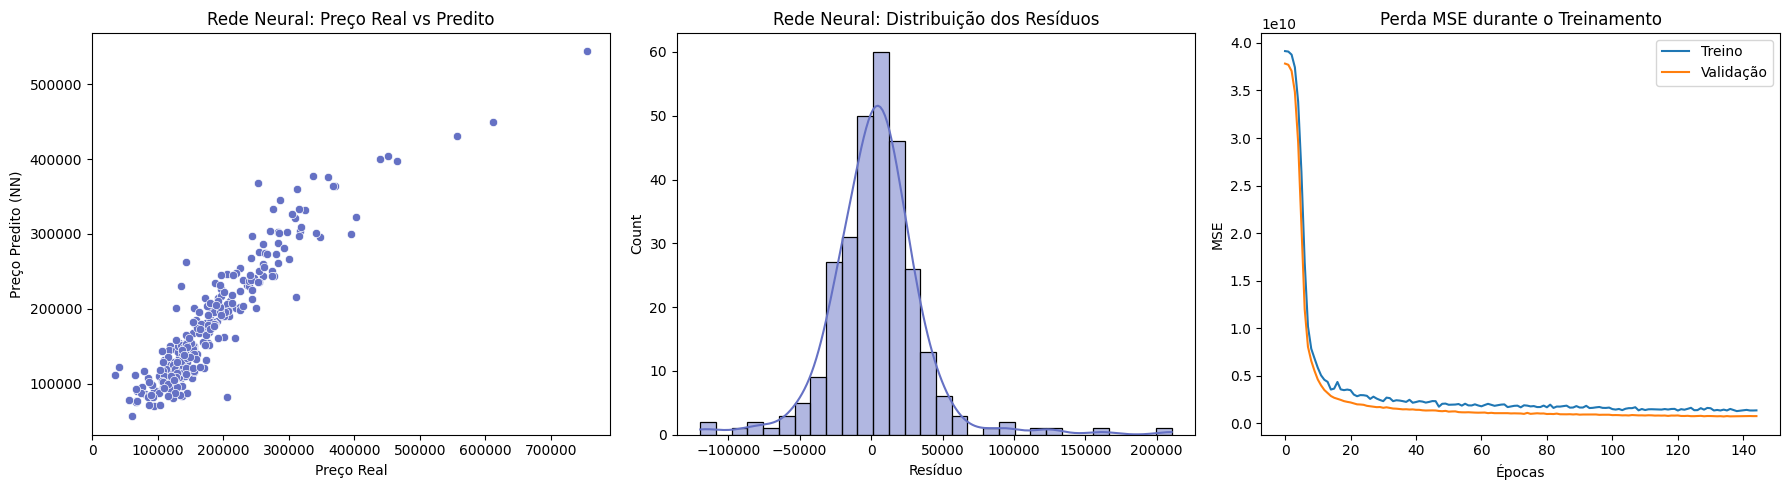

In [18]:
# Comparação entre real e previsto
plt.figure(figsize=(18, 5))

# Gráfico de dispersão
plt.subplot(1, 3, 1)
sns.scatterplot(x=y_test, y=y_pred_nn, color='#6571c4')
plt.xlabel("Preço Real")
plt.ylabel("Preço Predito (NN)")
plt.title("Rede Neural: Preço Real vs Predito")

# Resíduos
plt.subplot(1, 3, 2)
residuals_nn = y_test - y_pred_nn
sns.histplot(residuals_nn, bins=30, color='#6571c4', kde=True)
plt.title("Rede Neural: Distribuição dos Resíduos")
plt.xlabel("Resíduo")

# Curva de perda
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda MSE durante o Treinamento')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()

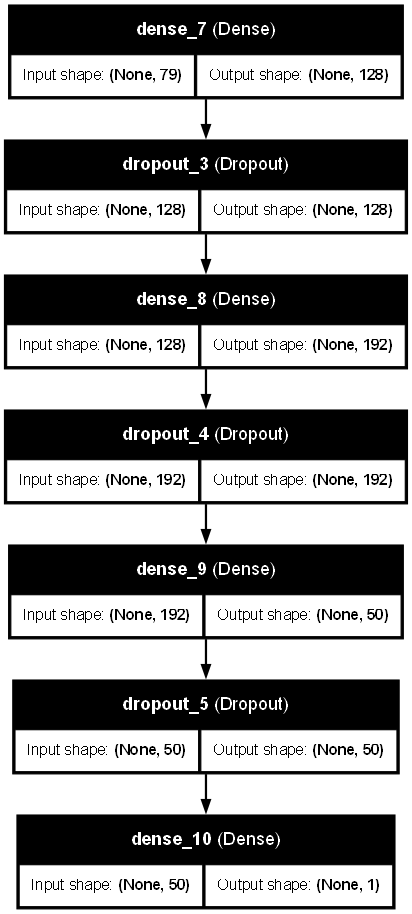

In [ ]:
plot_model(model_nn, show_shapes=True, show_layer_names=True, dpi=80)